# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (Input, Conv2D, AveragePooling2D, Flatten, Dense, Concatenate,
                                     Rescaling, MaxPooling2D, BatchNormalization, Dropout, Add,
                                     Multiply, GlobalAveragePooling2D, Activation, DepthwiseConv2D,
                                     Conv2DTranspose, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from datetime import datetime as dt
from tensorflow.keras.callbacks import TensorBoard

# Data DownLoading

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d jangedoo/utkface-new
! kaggle datasets download -d janwidziski/face-obstructions
! unzip "/content/utkface-new.zip" -d "/content/dataset"
! unzip "/content/face-obstructions.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/data/none/i14167.jpg  
  inflating: /content/dataset/data/none/i14168.jpg  
  inflating: /content/dataset/data/none/i14169.jpg  
  inflating: /content/dataset/data/none/i14170.jpg  
  inflating: /content/dataset/data/none/i14171.jpg  
  inflating: /content/dataset/data/none/i14172.jpg  
  inflating: /content/dataset/data/none/i14173.jpg  
  inflating: /content/dataset/data/none/i14174.jpg  
  inflating: /content/dataset/data/none/i14175.jpg  
  inflating: /content/dataset/data/none/i14176.jpg  
  inflating: /content/dataset/data/none/i14177.jpg  
  inflating: /content/dataset/data/none/i14178.jpg  
  inflating: /content/dataset/data/none/i14179.jpg  
  inflating: /content/dataset/data/none/i14180.jpg  
  inflating: /content/dataset/data/none/i14181.jpg  
  inflating: /content/dataset/data/none/i14182.jpg  
  inflating: /content/dataset/data/none/i14183.jpg  
  inflating: /content/dataset/data/none/i14184.j

# Data Loading

In [4]:
import shutil


In [5]:
# os.mkdir('/content/dataset/dataset')
classes = os.listdir('/content/dataset/data')
classes = [cls for cls in classes if cls not in ['none']]
data_path = "/content/dataset/data"
for cls in classes:
  for file in os.listdir(os.path.join(data_path, cls)):
    shutil.move(os.path.join(data_path, cls, file), "/content/dataset/dataset")

FileExistsError: ignored

In [2]:
face_images_path = "/content/dataset/UTKFace"
face_obs_images_path = "/content/dataset/dataset"

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
face_images = image_dataset_from_directory(face_images_path,
                                            labels = None,
                                            label_mode = None,
                                            color_mode ='rgb',
                                            batch_size = 64,
                                            image_size = (128, 128),
                                            shuffle =True,
                                            seed = 99)

Found 23708 files belonging to 1 classes.


In [5]:
face_obs_images = image_dataset_from_directory(face_obs_images_path,
                                              labels = None,
                                              label_mode = None,
                                              color_mode = 'rgb',
                                              batch_size = 64,
                                              image_size = (128, 128),
                                              shuffle = True,
                                              seed = 99)

Found 10608 files belonging to 1 classes.


# Train test split

In [6]:
def split_dataset(dataset, TRAIN_RATIO):
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(dataset_size * TRAIN_RATIO))
  test_dataset = dataset.skip(int(dataset_size * TRAIN_RATIO))

  return train_dataset, test_dataset

In [7]:
train_human_images, test_human_images = split_dataset(face_images, 0.80)

In [8]:
print("Number of Training Examples in Infected cell data:", len(train_human_images) * 64)
print("Number of Testing Examples in Infected cell data:", len(test_human_images) * 64)

Number of Training Examples in Infected cell data: 18944
Number of Testing Examples in Infected cell data: 4800


In [9]:
train_human_images = train_human_images.take(10000)
test_human_images = test_human_images.take(2000)
face_obs_images = face_obs_images.take(2000)

# Data Visulization

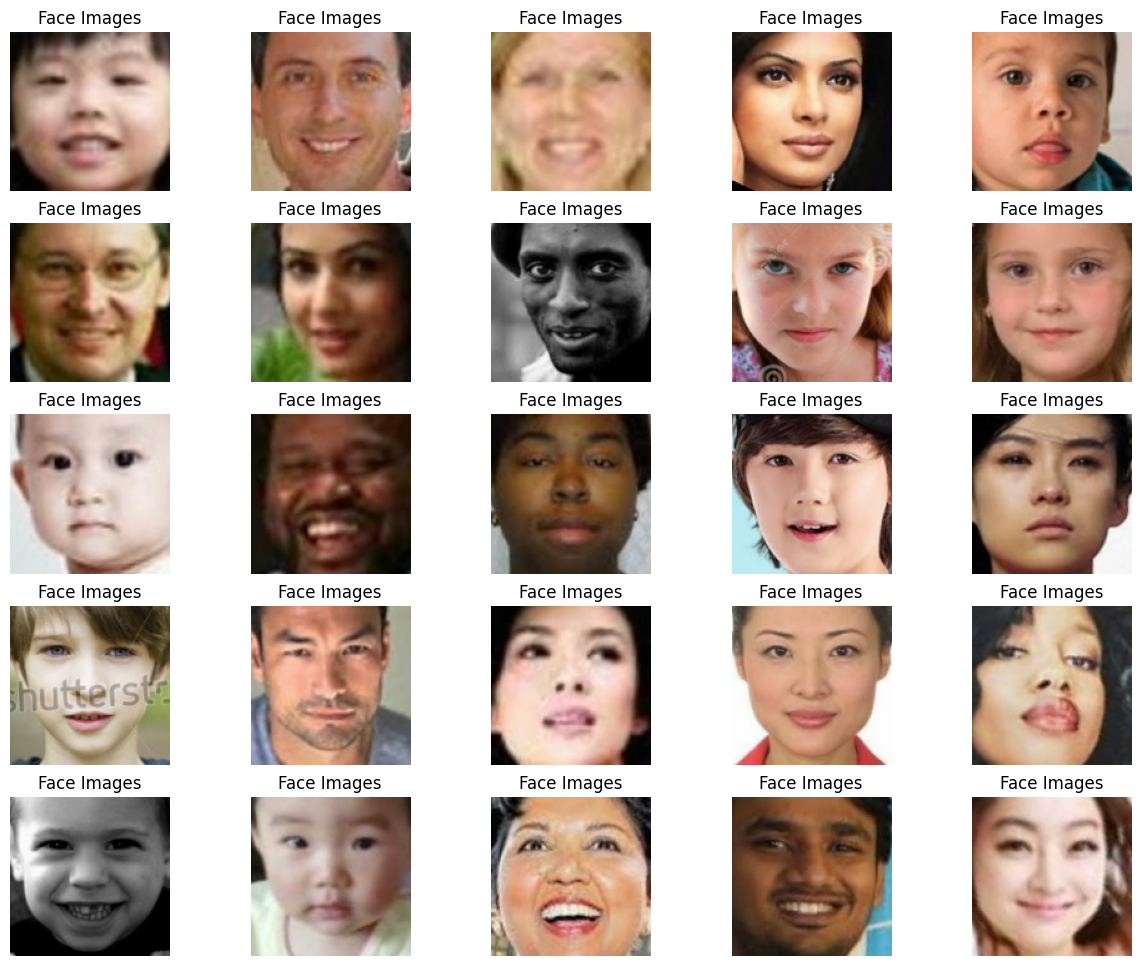

In [10]:
plt.figure(figsize=(15, 12))
for images in train_human_images.take(1):
  for i in range(25):
    plt.subplot(5, 5, i+1, xticks=[], yticks=[])
    plt.imshow(images[i]/255)
    plt.title("Face Images")
    plt.axis('off');

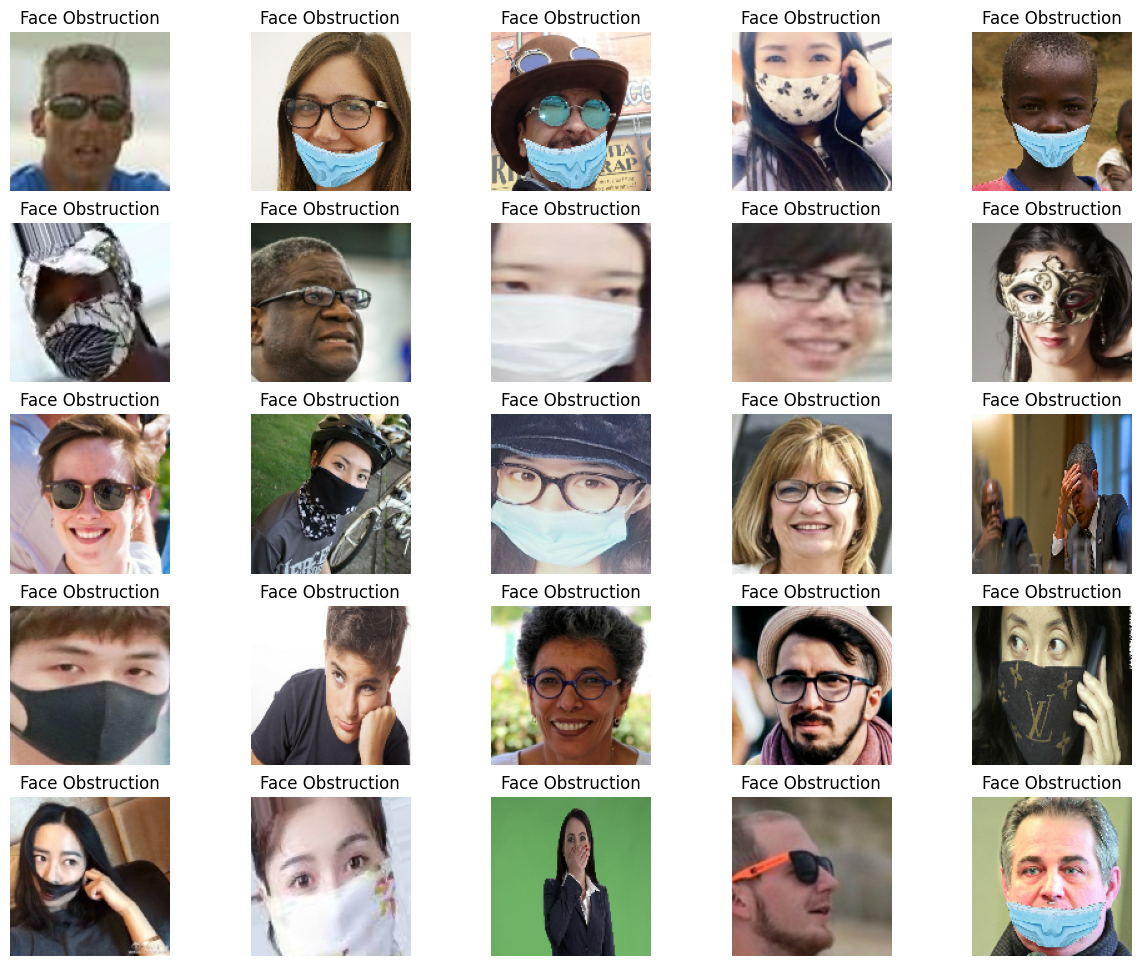

In [11]:
plt.figure(figsize=(15, 12))
for images in face_obs_images.take(1):
  for i in range(25):
    plt.subplot(5, 5, i+1, xticks=[], yticks=[])
    plt.imshow(images[i]/255)
    plt.title("Face Obstruction")
    plt.axis('off')

# Data Loading

In [12]:
train_human_images = (train_human_images
                    .shuffle(buffer_size=1024)
                    .prefetch(tf.data.AUTOTUNE))

In [13]:
test_human_images = (test_human_images
                    .shuffle(buffer_size=1024)
                    .prefetch(tf.data.AUTOTUNE))

In [14]:
face_obs_images = (face_obs_images
                  .shuffle(buffer_size=1024)
                  .prefetch(tf.data.AUTOTUNE))

# Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Lambda

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

LATENT_DIM = 128

base_model = VGG16(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
base_model.trainable = False

input_layer = Input(shape=(128, 128, 3))
preprocess_layer = preprocess_input(input_layer)

x = base_model(preprocess_layer, training=False)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
latent_mean = Dense(LATENT_DIM, name='latent_mean')(x)
latent_logvar = Dense(LATENT_DIM, name='latent_logvar')(x)

encoder_model = Model(inputs=input_layer, outputs=[latent_mean, latent_logvar])
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 128, 128, 3)          0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                              

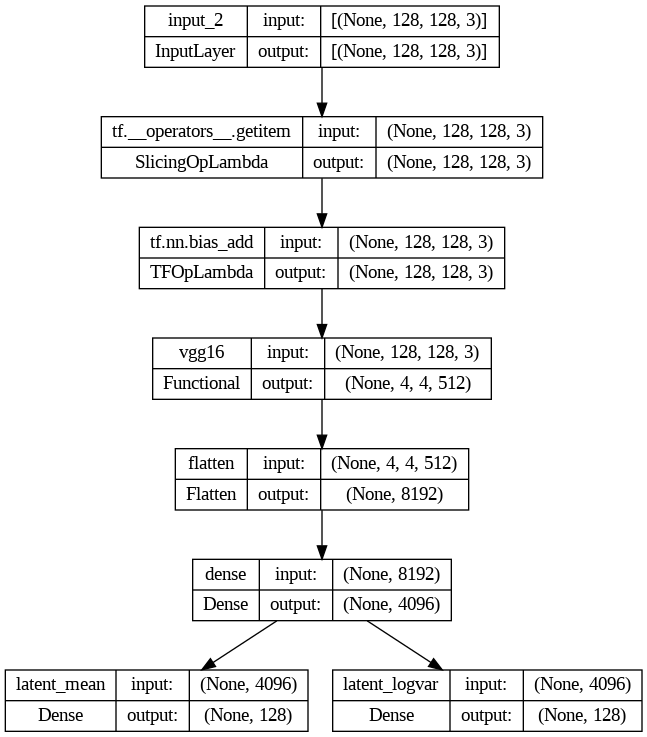

In [17]:
plot_model(encoder_model, show_shapes=True)

In [18]:
LATENT_DIM = 128

input_latent = layers.Input(shape=(LATENT_DIM,))
x = layers.Reshape((4, 4, 8))(input_latent)

upsample_filters = [512, 512, 256, 128, 64]
for filters in upsample_filters:
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

output_layer = layers.Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid')(x)

decoder_model = Model(inputs=input_latent, outputs=output_layer)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 8)           0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 512)         37376     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 8, 8, 512)         2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 512)       2359

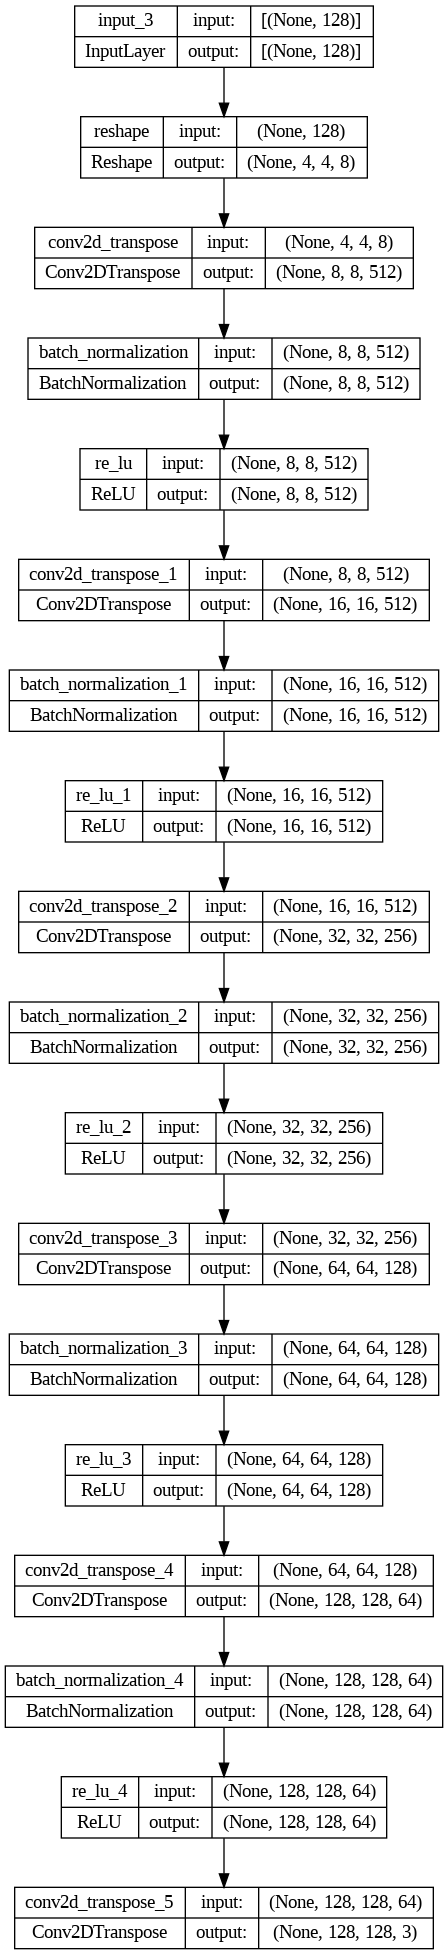

In [19]:
plot_model(decoder_model, show_shapes=True)

In [20]:
INPUT_SHAPE = (128, 128, 3)
LATENT_DIM = 128

def sampling(args):
    z_mean, z_logvar = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_logvar) * epsilon

In [21]:
def reconstruction_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

def kl_divergence_loss(z_mean, z_logvar):
    kl_loss = -0.5 * tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=-1)
    return tf.reduce_mean(kl_loss)

def custom_loss(y_true, y_pred, z_mean, z_logvar):
    recon_loss = reconstruction_loss(y_true, y_pred)
    kl_loss = kl_divergence_loss(z_mean, z_logvar)
    total_loss = recon_loss + kl_loss
    return total_loss

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, encoder_model, decoder_model, sampling):
        super(VAE, self).__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
        self.sampling = sampling
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x_batch):
        z_mean, z_logvar = self.encoder(x_batch)
        z = self.sampling([z_mean, z_logvar])  # Remove Lambda layer
        y_pred = self.decoder(z)
        return y_pred

    def train_step(self, x_batch):
        with tf.GradientTape() as recorder:
            z_mean, z_logvar = self.encoder(x_batch)
            z = self.sampling([z_mean, z_logvar])  # Remove Lambda layer
            y_pred = self.decoder(z)
            y_true = x_batch
            loss = custom_loss(y_true, y_pred, z_mean, z_logvar)

        partial_derivatives = recorder.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(partial_derivatives, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

In [23]:
from tensorflow.keras.optimizers import Adam
model = VAE(encoder_model, decoder_model, sampling)
OPTIMIZER = Adam(learning_rate=1e-3)
model.compile(optimizer=OPTIMIZER, loss=custom_loss)

history = model.fit(train_human_images,
                    validation_data=test_human_images,
                    epochs=1)

296/296 [==============================] - 131s 314ms/step - loss: nan - val_loss: 0.0000e+00


In [24]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['discriminator_loss'], label='Discriminator Loss', linestyle='-', color='b')
plt.plot(history.history['generator_loss'], label='Generator Loss', linestyle='--', color='r')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

KeyError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 12))
for batch_images in test_human_images.take(1):
  batch_prediction = model.predict(batch_images)
  for i in range(25):
      plt.subplot(5, 5, i+1, xticks=[], yticks=[])
      plt.imshow(batch_prediction[i]/255)
      plt.title("Generated images")
      plt.axis('off')

In [31]:
validation_error = model.evaluate_generator(test_human_images)
anomaly_error = model.evaluate_generator(face_obs_images)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

<ipython-input-31-a9bcb92d62af>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(test_human_images)
<ipython-input-31-a9bcb92d62af>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(face_obs_images)


Recon. error for the validation (normal) data is:  0.0
Recon. error for the anomaly data is:  0.0


# Generator Model

In [32]:
generated_images = []
for batch_images in test_human_images:
  batch_prediction = model.predict(batch_images)
  generated_images.extend(batch_prediction)

1/1 [==============================] - 3s 3s/step


In [44]:
output_vector_shape = 49152
encoded_images = [np.reshape(image, (output_vector_shape)) for image in generated_images]

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images)

In [ ]:
test_human_images = (test_human_images.unbatch())

In [ ]:
face_obs_images = (face_obs_images.unbatch())

In [ ]:
def calc_density_reconc_error(batch_images):
  density_list = []
  reconstruction_error_list = []
  for image in batch_images:
    image = tf.expand_dims(image, axis=0)
    image_gen = model.encoder.predict(image)
    encoded_image = np.reshape(image_gen, output_vector_shape)
    density = kde.score_samples(encoded_image)[0]
    reconstruction = model.predict(image)
    reconstruction_error = model.evaluate([reconstruction, image], batch_size=1)[0]
    density_list.append(density)
    reconstruction_error_list.append(reconstruction_error)

  average_density = np.mean(np.array(density_list))
  stdev_density = np.std(np.array(density_list))
  avg_recon_error = np.mean(np.array(reconstruction_error_list))
  stddev_recon_error = np.std(np.array(reconstruction_error_list))

  return average_density, stdev_density, avg_recon_error, stddev_recon_error

In [ ]:
average_density, stdev_density, avg_recon_error, stddev_recon_error = calc_density_reconc_error(test_human_images)
print("Average Density value of normal face images is:", average_density)
print("Standard Deviation value of normal face images is:", stdev_density)
print("Average Reconstruction error value of normal face images is: ", avg_recon_error)
print("Standard Deviation value of normal face images is:", stddev_recon_error)

In [ ]:
average_density, stdev_density, avg_recon_error, stddev_recon_error = calc_density_reconc_error(face_obs_images)
print("Average Density value of Anomaly face images is:", average_density)
print("Standard Deviation value of Anomaly face images is:", stdev_density)
print("Average Reconstruction error value of Anomaly face images is: ", avg_recon_error)
print("Standard Deviation value of Anomaly face images is:", stddev_recon_error)

In [ ]:
def check_anomaly(image_path):

  density_threshold = ---
  reconstruction_error_threshold = ----

  image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
  image = tf.cast(tf.image.resize(image, [128, 128]), dtype=tf.float32)
  plt.imshow(image)

  image = tf.expand_dims(image, axis=0)
  encoded_image = model.encoder.predict(image)
  encoded_image = np.reshape(encoded_image, output_vector_shape)

  density = kde.score_samples(encoded_image)[0]
  reconstruced_image = model.predict(image)
  reconstruction_error = model.evaluate([reconstruced_image, image], batch_size=1)[0]

  if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
    print("The image is an anomaly")
  else:
    print("The image is NOT an anomaly")

In [ ]:
check_anomaly()

In [ ]:
check_anomaly()